In [1]:
from connectFourEnv import ConnectFourEnv
from dqn_net_connect import CNNCom
# from equivariant_dqn_net_larger import EquivariantCNNCom
from memory_connect import ReplayMemory
from utils.schedules import LinearSchedule

import copy
import tqdm
import torch
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
class LinearSchedule(object):
    """ This schedule returns the value linearly"""
    def __init__(self, start_value, end_value, duration):
        self._start_value = start_value
        self._end_value = end_value
        self._duration = duration
        self._schedule_amount = end_value - start_value

    def value(self, time):
        # logic: if time > duration, use the end value, else use the scheduled value
        return self._start_value + self._schedule_amount * min(1.0, time * 1.0 / self._duration)

def evaluate(dqn_model, env, eps=0.1, equi=False):
    obs = env.reset()
    done = False
    rewards = []
    actions = []
    
    for _ in range(500): # timeout at 500 steps
        # get greedy action
        if np.random.rand() < eps:
            action = np.random.choice(range(4))
        else:
            obs_tensor = torch.tensor(obs.copy(), dtype=torch.float32).unsqueeze(0)
            if equi:
                obs_tensor = obs_tensor.unsqueeze(0)
            q_values = dqn_model(obs_tensor)  # add dim to observation
            max_q_idx = torch.where(q_values == q_values.max())[0]
            action = np.random.choice(max_q_idx.tolist())
    
        obs, reward, done = env.step(action)
        rewards.append(reward)

        if done:
            break
    # env.render()
    g = 0
    for r in rewards[::-1]:
        g = 0.99*g + r
    return g

exploration = LinearSchedule(1, .1, 500_000)

In [3]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance
    :param batch: Batch of experiences (class defined earlier)
    :param dqn_model: The DQN model to be trained
    :param dqn_target: The target DQN model, ~NOT~ to be trained
    :param gamma: The discount factor
    :rtype: Float. The scalar loss associated with this batch
    """
  
    values = dqn_model(batch.observations).gather(1, batch.actions)

    with torch.no_grad():
        next_q = dqn_target(batch.next_observations).max(1)[0].view(-1, 1)
        target_values = batch.rewards + gamma * next_q * (~batch.dones)

    loss = F.smooth_l1_loss(values, target_values)  # CHANGED

    optimizer.zero_grad()  # Reset all previous gradients
    loss.backward()  # Compute new gradients
    optimizer.step()  # Perform one gradient-descent step

    return loss.item()

In [4]:
params = {"num_steps": 500_000,
          "num_saves": 5,
          "replay_size": 200_000,
          "replay_prepopulate_steps": 50_000,
          "batch_size": 64,
          "state_size": 2,
          "gamma": 0.99,
          "model": "regular",
          "checkpoint": None,
          "checkpoint_t": 0} # equi or regular 

# for run_number in [2]:
    # def train_dqn(env, exploration, params):
env = ConnectFourEnv()
eval_env = ConnectFourEnv()

# Initialize the DQN and DQN-target models
if params["model"] == "regular":
    dqn_model = CNNCom()
    dqn_target = CNNCom()#.custom_load(dqn_model.custom_dump())
else:
    dqn_model = EquivariantCNNCom()
    dqn_target = EquivariantCNNCom()
    dqn_model.train()
    dqn_target.train()

if params["checkpoint"] is not None:
    checkpoint = torch.load(params["checkpoint"])
    dqn_model.load_state_dict(checkpoint["100_0"]["state_dict"])
    dqn_target.load_state_dict(checkpoint["100_0"]["state_dict"])
    
# Initialize the optimizer
optimizer = torch.optim.Adam(dqn_model.parameters(), lr=1e-3)

# Initialize the replay memory and prepopulate it
memory = ReplayMemory(params["replay_size"], env.grid.shape, torch.device("cpu"))
memory.populate(env, params["replay_prepopulate_steps"])

# Initialize lists to store returns, lengths, and losses
rewards = []
returns = []
lengths = []
losses = []
evals = []

# # Initialize structures to store the models at different stages of training
t_saves = np.linspace(0, params["num_steps"], params["num_saves"] - 1, endpoint=False)
saved_models = {}

i_episode = 0  # Use this to indicate the index of the current episode
t_episode = 0  # Use this to indicate the time-step inside current episode

obs = env.reset()  # Initialize state of first episode
G=0

pbar = tqdm.trange(params["num_steps"])
for t_total in pbar:

    # Save model
    if t_total in t_saves:
        model_name = f'{100 * t_total / params["num_steps"]:04.1f}'.replace('.', '_')
        saved_models[model_name] = copy.deepcopy(dqn_model)

    # get action using e-greedy
    eps = exploration.value(t_total + params["checkpoint_t"])  # get current epsilon value
    # eps = 0.1
    if np.random.rand() < eps:
        action = np.random.choice(env.action_space)
    else:
        with torch.no_grad():
            q_values = dqn_model(torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0))  # add dim to observation
            max_q_idx = torch.where(q_values == q_values.max())[0]
            action = np.random.choice(max_q_idx.tolist())
        
    # step forward env
    next_obs, reward, done = env.step(action)

    # add transition to memory
    memory.add(obs, action, reward, next_obs, done)

    if t_total%4 == 0:
        batch = memory.sample(params["batch_size"])
        loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, params["gamma"])
        losses.append(loss)

    if t_total%10000 == 0:
        dqn_target.load_state_dict(dqn_model.state_dict())

    if t_total%1000 == 0:
        evals.append(evaluate(dqn_model, eval_env, 0.1, params["model"]=="equi"))
        pbar.set_description(
            f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {evals[-1]:5.2f} | Epsilon: {eps:4.2f}'
        )

    if done:
        rewards.append(reward)
        G = 0
        for r in rewards[::-1]:
            G = params["gamma"] * G + r

        returns.append(G)
        lengths.append(t_episode)

        # reset
        t_episode = 0
        i_episode += 1
        rewards = []
        obs = env.reset()
        
    else:
        # state = next_state
        obs = np.copy(next_obs)
        t_episode += 1
        rewards.append(reward)

saved_models['100_0'] = copy.deepcopy(dqn_model)

# with open(f"equi_run{run_number}.npy", "wb") as f:
#     np.save(f, np.array(evals))
#     np.save(f, np.array(returns))

Episode: 57856 | Steps: 6 | Return:  9.61 | Epsilon: 0.10: 100%|███████████████| 500000/500000 [20:01<00:00, 416.09it/s]


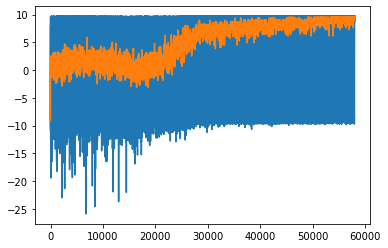

In [7]:
plt.plot(returns)
plt.plot(moving_average(returns))

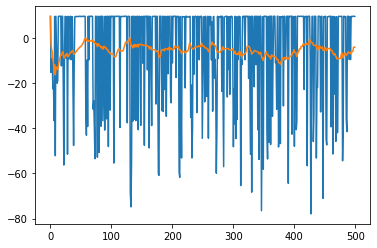

In [9]:
plt.plot(evals)
plt.plot(moving_average(evals))

In [42]:
dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0))

tensor([10.3704,  9.5909,  6.9593,  9.2720,  5.8421, 11.8680, 12.4724],
       grad_fn=<SqueezeBackward0>)

In [43]:
with open(f"connect4_regular_run1.npy", "wb") as f:
    np.save(f, np.array(evals))
    np.save(f, np.array(returns))
    np.save(f, np.array(losses))

In [18]:
[evaluate(dqn_model, eval_env) for _ in range(10)]

[9.509900498999999,
 -25.550961541125037,
 9.414801494009998,
 -44.09434690643801,
 9.70299,
 9.605960099999999,
 -11.812148039906596,
 9.509900498999999,
 9.605960099999999,
 9.605960099999999]

In [ ]:
def custom_dump(dqn):
    return {
        # 'args': (2, 9),
        # 'kwargs': {
        #     'num_layers': 3,
        #     'hidden_dim': 1,
        # },
        'state_dict': dqn.state_dict(),
    }

checkpoint = {key: custom_dump(dqn) for key, dqn in saved_models.items()}
torch.save(checkpoint, f'fourrooms_200000_to_400000_steps.pt')

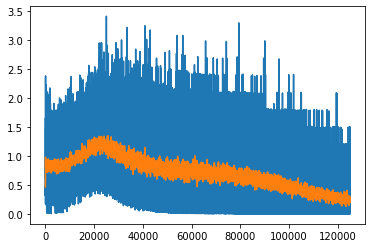

In [10]:
plt.plot(losses)
plt.plot(moving_average(losses))

In [ ]:
plt.plot(losses)

In [ ]:
with open(f"four_room_regular_2000000_run1.npy", "wb") as f:
    np.save(f, np.array(returns))

In [ ]:
"""Plot function similar to Ex1"""
def plot_curves(arr_list, legend_list, color_list, ylabel):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    plt.clf()
    fig, ax = plt.subplots()

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Episodes")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(0, 1000*arr.shape[1], 1000), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err = 1.96 * arr_err
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.legend(handles=h_list)
    ax.set_title('Evaluated Returns - Rotated Maze')
    plt.show()

In [ ]:
min_len = min([len(r) for r in returns_equi])
returns_equi = [r[:min_len] for r in returns_equi]

min_len = min([len(r) for r in returns])
returns = [r[:min_len] for r in returns]

In [ ]:
plot_curves([np.array(eval_rot), np.array(eval_rot_equi)], ['Regular DQN', 'Equivariant DQN'], ['C0', 'C1', 'C2', 'C3', 'C4'], 'Returns')

In [ ]:
plot_curves([np.array(eval_reg_equi)], 'Equivariant DQN', ['C1', 'C2', 'C3', 'C4'], 'Returns')

In [ ]:
def custom_dump(dqn):
    return {
        # 'args': (2, 9),
        # 'kwargs': {
        #     'num_layers': 3,
        #     'hidden_dim': 1,
        # },
        'state_dict': dqn.state_dict(),
    }

checkpoint = {key: custom_dump(dqn) for key, dqn in saved_models.items()}
torch.save(checkpoint, f'dim7_runs250000_4actions_FIXED.pt')

In [ ]:
checkpoint = torch.load("dim7_runs25000_4actions.pt")
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
i = 0

for key, value in checkpoint.items():
    dqn = CNNCom()
    dqn.load_state_dict(value["state_dict"])

    g_arr = []
    for _ in range(10):
        g, _ = evaluate(dqn, env, 0.1)
        g_arr.append(g)
    plt.plot(g_arr, '.', color=colors[i], label=f"{key}: {np.mean(g_arr)}")
    plt.axhline(np.mean(g_arr), color=colors[i])
    i += 1

# plt.plot([0, 9], [0.932, .932], 'g', label='optimal rewards')
plt.legend()

In [ ]:
x = np.zeros(env.grid.shape)
x[tuple(env.start_state)] = 1

In [ ]:
np.argwhere(np.rot90(x, 2))[0]

In [ ]:
dqn = CNNCom()
dqn.load_state_dict(checkpoint["50_0"]["state_dict"])

In [ ]:
dqn = CNNCom()

In [ ]:
dqn(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0))[0]

In [ ]:
rewards = [-1, -1, -1, -1, -1, -1, -1, 1]
g=0
for r in rewards[::-1]:
    g = .99*g + r

In [ ]:
maze = MazeEnv(3, 123)
maze_rot = MazeEnv(3, 123, maze.grid, 1)

In [ ]:
maze_rot.grid

In [ ]:
env.step(7)
print(env.grid)
x = (dqn_model(torch.tensor(env.grid.copy(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)).reshape(3, 3))
for y in x:
    print(f"{y[0]}\t{y[1]}\t{y[2]}")

In [ ]:
q_values = dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0))  # add dim to observation
max_q_idx = torch.where(q_values == q_values.max())[0]
print((max_q_idx.tolist()))

In [ ]:
x = (dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0)).reshape(3, 3))
for y in x:
    print(f"{y[0]}\t{y[1]}\t{y[2]}")
        

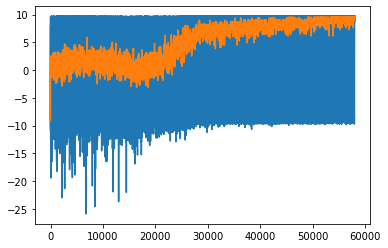

In [6]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

plt.plot(returns)
plt.plot(moving_average(returns))

In [ ]:
checkpoint = torch.load("dim7_runs250000_4actions_equi.pt")

In [ ]:
dqn = EquivariantCNNCom()
dqn.load_state_dict(checkpoint["100_0"]["state_dict"])
maze = MazeEnv(3, 123)

In [ ]:
g = [evaluate(dqn, maze, 0.01)[0] for _ in range(20)]

In [ ]:
maze_rot = MazeEnv(3, 123, maze.grid, 1)
maze_rot.reset()

In [ ]:
g_rot = [evaluate(dqn, maze_rot, 0.01)[0] for _ in range(20)]

In [ ]:
g_rot

In [ ]:
# manually evaluate equi dqn
env.reset()

In [ ]:
env.step(5)

In [ ]:
q_values = dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0))  # add dim to observation
max_q_idx = torch.where(q_values == q_values.max())[0]
print((max_q_idx.tolist()))

In [ ]:
q_values

In [ ]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

plt.plot(returns)
plt.plot(moving_average(returns))

In [ ]:
g_equi = [evaluate(dqn_model, maze, 0.01, True)[0] for _ in range(20)]

In [ ]:
maze_rot.reset()
maze_rot.render()

In [ ]:
maze_rot = MazeEnv(3, 123, maze.grid, 1)
maze_rot.reset()
# g_rot_equi = [evaluate(dqn_model, maze_rot, 0.01, True)[0] for _ in range(20)]

In [ ]:
g_rot_equi

In [ ]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

plt.plot(returns)
plt.plot(moving_average(returns))